# Automated ML

Check Azure ML SDK version

Import all dependencies needed

In [1]:
import azureml.core

azureml.core.__version__

'1.18.0'

In [2]:
import os
import json
import pickle
import logging
import requests
import warnings

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from azureml.data.tabular_dataset import TabularDataset

from azureml.core import Workspace, Datastore, Dataset, Experiment
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.model import InferenceConfig, Model
from azureml.core.webservice import Webservice, AciWebservice

from azureml.automl.core.shared import constants
from azureml.automl.core.forecasting_parameters import ForecastingParameters
from azureml.automl.runtime.shared.score import scoring

from azureml.train.automl import AutoMLConfig
from azureml.train.automl.run import AutoMLRun

from azureml.widgets import RunDetails

In [3]:
warnings.filterwarnings("ignore")

# configure matplotlib
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,5)

# configure pandas dataframe options
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 20)
pd.set_option('display.max_colwidth', 20)

pd.options.display.float_format = '{:,.5f}'.format
pd.__version__

'0.25.3'

## Dataset

This dataset is published on [Kaggle](https://www.kaggle.com/c/rossmann-store-sales). It presents sales data from the Rossmann which operates over 3,000 drug stores in 7 European countries. Store sales are collected by days and influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality.  


The notebook leverages Azure AutoML capability to find the best model performance in order to help Rossmann store managers predict their daily sales for up to six weeks in advance. The best model found here will be compared against the one generated by Hyperdrive and Prophet.

In [4]:
# used to extract holidays
def get_holidays(df):
    state_dates = np.unique(df[(df['StateHoliday'] == 'a') | (df['StateHoliday'] == 'b') & (df['StateHoliday'] == 'c')].loc[:, 'Date'].values)
    school_dates = np.unique(df[df['SchoolHoliday'] == 1].loc[:, 'Date'].values)

    # from the Prophet documentation every variables should have specific names
    state = pd.DataFrame({
        'holiday': 'state_holiday',
        'ds': pd.to_datetime(state_dates)
    })

    school = pd.DataFrame({
        'holiday': 'school_holiday',
        'ds': pd.to_datetime(school_dates)
    })

    return pd.concat((state, school))  

In [5]:
# load train dataset
train = pd.read_csv('data/train.csv', parse_dates=True, low_memory=False)

# remove closed stores and those with no sales -- ALL STORES
#train = train[(train['Open'] != 0) & (train['Sales'] != 0)]

# extract data from a specific store -- STORE 1, TYPE C
train = train[train['Store'] == 1]

# extract holidays
holidays = get_holidays(train)

# drop Customers column since forecast dataset does not have it -- ALL STORES
#train = train.drop(['Open', 'Customers'], axis='columns')

# drop Customers column since forecast dataset does not have it -- STORE 1, TYPE C
train = train.drop(['Customers', 'Store'], axis='columns')

# verify missing values
train.isnull().sum()

DayOfWeek        0
Date             0
Sales            0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [7]:
train

,DayOfWeek,Date,Sales,Open,Promo,StateHoliday,SchoolHoliday
0,5,2015-07-31,5263,1,1,0,1
1115,4,2015-07-30,5020,1,1,0,1
2230,3,2015-07-29,4782,1,1,0,1
3345,2,2015-07-28,5011,1,1,0,1
4460,1,2015-07-27,6102,1,1,0,1
...,...,...,...,...,...,...,...
1011635,6,2013-01-05,4997,1,0,0,1
1012750,5,2013-01-04,4486,1,0,0,1
1013865,4,2013-01-03,4327,1,0,0,1
1014980,3,2013-01-02,5530,1,0,0,1


In [8]:
# load forecast dataset
forecast = pd.read_csv('data/forecast.csv', parse_dates=True, low_memory=False)

# remove closed stores and those with no sales -- ALL STORES
#forecast = forecast[forecast['Open'] != 0]

# extract data from a specific store -- STORE 1, TYPE C
forecast = forecast[forecast['Store'] == 1]

# extract holidays
holidays = pd.concat((holidays, get_holidays(forecast)))

# drop Id column since there is no value added -- ALL STORES
#forecast = forecast.drop(['Id', 'Open'], axis='columns')

# drop Id column since there is no value added -- STORE 1, TYPE C
forecast = forecast.drop(['Id', 'Store'], axis='columns')

# verify missing values
forecast.isnull().sum()

DayOfWeek        0
Date             0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [9]:
forecast

,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,4,2015-09-17,1.00000,1,0,0
856,3,2015-09-16,1.00000,1,0,0
1712,2,2015-09-15,1.00000,1,0,0
2568,1,2015-09-14,1.00000,1,0,0
3424,7,2015-09-13,0.00000,0,0,0
...,...,...,...,...,...,...
36808,3,2015-08-05,1.00000,1,0,1
37664,2,2015-08-04,1.00000,1,0,1
38520,1,2015-08-03,1.00000,1,0,1
39376,7,2015-08-02,0.00000,0,0,1


In [ ]:
# -- ALL STORES

# load store dataset
#store = pd.read_csv('data/store.csv', low_memory = False)

# drop PromoInterval column to make life simpler :)
#store = store.drop('PromoInterval', axis='columns')

# Only care about store 1, type C
#store = store[store['Store'] == 1] 

# verify missing values
#store.isnull().sum()

In [ ]:
# -- ALL STORES

# fill missing CompetitionDistance with median value of all presenting distances
#store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace=True)

# fill 0 for other missing values
#store.fillna(0, inplace=True)

#store.isnull().sum()

In [ ]:
# -- ALL STORES

#store.head()

In [ ]:
# -- ALL STORES

# merge train and store datasets, sort by date to generate final training dataset
#train_store = pd.merge(train, store, how='inner', on='Store').set_index('Date').sort_index(ascending=True).reset_index()
#train_store.head()

In [ ]:
# -- ALL STORES

# verify data types
#train_store.info()

In [ ]:
# -- ALL STORES

# set float64 to int64 since there is no need to store them as floats
#train_store = train_store.astype({
#    'CompetitionDistance': 'int64',
#    'CompetitionOpenSinceMonth': 'int64',
#    'CompetitionOpenSinceYear': 'int64',
#    'Promo2SinceWeek': 'int64',
#    'Promo2SinceYear': 'int64'
#})
#train_store.info()

In [10]:
# -- STORE 1, TYPE C

# sort Date column since its time-series is in reserved order
train_store = train.set_index('Date').sort_index(ascending=True).reset_index()
train_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 942 entries, 0 to 941
Data columns (total 7 columns):
Date             942 non-null object
DayOfWeek        942 non-null int64
Sales            942 non-null int64
Open             942 non-null int64
Promo            942 non-null int64
StateHoliday     942 non-null object
SchoolHoliday    942 non-null int64
dtypes: int64(5), object(2)
memory usage: 51.6+ KB


In [11]:
# split train dataset to training and testing datasets
split_date = '2015-01-01'

test_store = train_store[train_store['Date'] >= split_date]
test_store

,Date,DayOfWeek,Sales,Open,Promo,StateHoliday,SchoolHoliday
730,2015-01-01,4,0,0,0,a,1
731,2015-01-02,5,5509,1,0,0,1
732,2015-01-03,6,5023,1,0,0,1
733,2015-01-04,7,0,0,0,0,1
734,2015-01-05,1,6239,1,1,0,1
...,...,...,...,...,...,...,...
937,2015-07-27,1,6102,1,1,0,1
938,2015-07-28,2,5011,1,1,0,1
939,2015-07-29,3,4782,1,1,0,1
940,2015-07-30,4,5020,1,1,0,1


In [12]:
train_store = train_store[train_store['Date'] < split_date]
train_store

,Date,DayOfWeek,Sales,Open,Promo,StateHoliday,SchoolHoliday
0,2013-01-01,2,0,0,0,a,1
1,2013-01-02,3,5530,1,0,0,1
2,2013-01-03,4,4327,1,0,0,1
3,2013-01-04,5,4486,1,0,0,1
4,2013-01-05,6,4997,1,0,0,1
...,...,...,...,...,...,...,...
725,2014-12-27,6,6057,1,0,0,1
726,2014-12-28,7,0,0,0,0,1
727,2014-12-29,1,6463,1,0,0,1
728,2014-12-30,2,6466,1,0,0,1


In [ ]:
# -- ALL STORES

# merge forecast and store datasets, sort by date to generate final forecast dataset
#forecast_store = pd.merge(forecast, store, how='inner', on='Store').set_index('Date').sort_index(ascending=True).reset_index()
#forecast_store.head()

In [ ]:
# -- ALL STORES

# verify data types
#forecast_store.info()

In [ ]:
# -- ALL STORES

# set float64 to int64 since there is no need to store them as floats
#forecast_store = forecast_store.astype({
#    'CompetitionDistance': 'int64',
#    'CompetitionOpenSinceMonth': 'int64',
#    'CompetitionOpenSinceYear': 'int64',
#    'Promo2SinceWeek': 'int64',
#    'Promo2SinceYear': 'int64'
#})
#forecast_store.info()

In [13]:
# -- STORE 1, TYPE C

# sort Date column since its time-series is in reserved order
forecast_store = forecast.set_index('Date').sort_index(ascending=True).reset_index()
forecast_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 6 columns):
Date             48 non-null object
DayOfWeek        48 non-null int64
Open             48 non-null float64
Promo            48 non-null int64
StateHoliday     48 non-null object
SchoolHoliday    48 non-null int64
dtypes: float64(1), int64(3), object(2)
memory usage: 2.4+ KB


In [14]:
# -- STORE 1, TYPE C

# set float64 to int64 since there is no need to store them as floats
forecast_store = forecast_store.astype({
    'Open': 'int64'
})
forecast_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 6 columns):
Date             48 non-null object
DayOfWeek        48 non-null int64
Open             48 non-null int64
Promo            48 non-null int64
StateHoliday     48 non-null object
SchoolHoliday    48 non-null int64
dtypes: int64(4), object(2)
memory usage: 2.4+ KB


In [15]:
forecast_store

,Date,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday
0,2015-08-01,6,1,0,0,1
1,2015-08-02,7,0,0,0,1
2,2015-08-03,1,1,1,0,1
3,2015-08-04,2,1,1,0,1
4,2015-08-05,3,1,1,0,1
...,...,...,...,...,...,...
43,2015-09-13,7,0,0,0,0
44,2015-09-14,1,1,1,0,0
45,2015-09-15,2,1,1,0,0
46,2015-09-16,3,1,1,0,0


In [16]:
# sort 'ds' column since its time-series is in reserved order
holidays = holidays.set_index('ds').sort_index(ascending=True).reset_index()
holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245 entries, 0 to 244
Data columns (total 2 columns):
ds         245 non-null datetime64[ns]
holiday    245 non-null object
dtypes: datetime64[ns](1), object(1)
memory usage: 4.0+ KB


In [17]:
holidays

,ds,holiday
0,2013-01-01,state_holiday
1,2013-01-01,school_holiday
2,2013-01-02,school_holiday
3,2013-01-03,school_holiday
4,2013-01-04,school_holiday
...,...,...
240,2015-08-31,school_holiday
241,2015-09-01,school_holiday
242,2015-09-02,school_holiday
243,2015-09-03,school_holiday


In [18]:
# dataset details
data_folder = 'data'

train_dataset_name = 'sales_train1'
train_dataset_file = f'{data_folder}/train_store1.csv'
print(train_dataset_name, train_dataset_file)

test_dataset_name = 'sales_test1'
test_dataset_file = f'{data_folder}/test_store1.csv'
print(test_dataset_name, test_dataset_file)

forecast_dataset_name = 'sales_forecast1'
forecast_dataset_file = f'{data_folder}/forecast_store1.csv'
print(forecast_dataset_name, forecast_dataset_file)

holiday_dataset_name = 'sales_holiday1'
holiday_dataset_file = f'{data_folder}/holiday1.csv'
print(holiday_dataset_name, holiday_dataset_file)


sales_train1 data/train_store1.csv
sales_test1 data/test_store1.csv
sales_forecast1 data/forecast_store1.csv
sales_holidays data/holidays.csv


In [19]:
# save final train, test, holidays, and forecast datasets
train_store.to_csv(train_dataset_file, index=False)
test_store.to_csv(test_dataset_file, index=False)
forecast_store.to_csv(forecast_dataset_file, index=False)
holidays.to_csv(holiday_dataset_file, index=False)

### Register datasets with Azure 
Make sharing the same datasets with Hyperdrive tuning solution

In [20]:
# connect to Azure workspace
ws = Workspace.from_config(
      path='./config.json'
)

print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep = '\n')

Workspace name: soil_salinity
Azure region: westus
Subscription id: b5871718-8318-4393-a54a-0b866c2ff9ac
Resource group: ai_for_earth


In [21]:
# obtain default datastore from Azure
ds = ws.get_default_datastore()
ds

{
  "name": "workspaceblobstore",
  "container_name": "azureml-blobstore-a0a6b41f-3687-40c0-84ab-536b25bad01a",
  "account_name": "soilsalinity6956085569",
  "protocol": "https",
  "endpoint": "core.windows.net"
}

In [22]:
# register datasets with Azure
def register_dataset(name, file, workspace, datastore):
    dataset = None
    
    if name in workspace.datasets:
        dataset = workspace.datasets[name]
        if dataset and type(dataset) is TabularDataset:
            print('Found dataset:', name)
            return dataset

    datastore.upload_files(files=[file], target_path=data_folder, overwrite=True, show_progress=True)

    dataset = Dataset.Tabular.from_delimited_files(path = [(ds, (file))])
    dataset = dataset.with_timestamp_columns(timestamp='date')  # assign 'date' column as timestamp

    dataset = dataset.register(workspace=workspace, name=name, description=f'Dataset {name}')
    print('New base dataset registered:', name)

    return dataset

In [23]:
# upload and register datasets if needed
train_dataset = register_dataset(train_dataset_name, train_dataset_file, ws, ds)
test_dataset = register_dataset(test_dataset_name, test_dataset_file, ws, ds)
forecast_dataset = register_dataset(forecast_dataset_name, forecast_dataset_file, ws, ds)
holiday_dataset = register_dataset(holiday_dataset_name, holiday_dataset_file, ws, ds)

Found dataset: sales_train1
Found dataset: sales_test1
Found dataset: sales_forecast1
Found dataset: sales_holidays


In [ ]:
# run this cell if datasets were manually registered
#train_dataset = Dataset.get_by_name(ws, name=train_dataset_name)
#test_dataset = Dataset.get_by_name(ws, name=test_dataset_name)
#forecast_dataset = Dataset.get_by_name(ws, name=forecast_dataset_name)

In [24]:
train_dataset.to_pandas_dataframe().reset_index(drop=True).tail(5)

,Date,DayOfWeek,Sales,Open,Promo,StateHoliday,SchoolHoliday
725,2014-12-27,6,6057,1,0,0,1
726,2014-12-28,7,0,0,0,0,1
727,2014-12-29,1,6463,1,0,0,1
728,2014-12-30,2,6466,1,0,0,1
729,2014-12-31,3,2605,1,0,0,1


In [25]:
test_dataset.to_pandas_dataframe().reset_index(drop=True).head(5)

,Date,DayOfWeek,Sales,Open,Promo,StateHoliday,SchoolHoliday
0,2015-01-01,4,0,0,0,a,1
1,2015-01-02,5,5509,1,0,0,1
2,2015-01-03,6,5023,1,0,0,1
3,2015-01-04,7,0,0,0,0,1
4,2015-01-05,1,6239,1,1,0,1


In [26]:
forecast_dataset.to_pandas_dataframe().reset_index(drop=True).head(5)

,Date,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday
0,2015-08-01,6,1,0,0,1
1,2015-08-02,7,0,0,0,1
2,2015-08-03,1,1,1,0,1
3,2015-08-04,2,1,1,0,1
4,2015-08-05,3,1,1,0,1


## AutoML Configuration

1. Create a model training compute cluster with 4 nodes, each node is a CPU base compute with 4 cores, 14GB RAM, and 28GB storage
2. Use time-series based forecasting models, except ARIMA and Prophet since they do not support the dataset structure
3. Do not engage Deep Learning modeling algorithms
4. Primary metric: Optimize model performance by Normalized Root Mean Squared Error (NRMSE) in order to find the best model
5. Use 5 folds (n_cross_validation) in cross validation: 4 folds for training and 1 fold for testing
6. Utilize 4 nodes in the training cluster with all cores possible
7. Run experiment for 30 minutes
8. Target column is 'Sales' in the datasets
9. Forecast 6 weeks in the future

In [27]:
# create remote compute cluster if needed
compute_name = 'train-compute'
vm_size = 'STANDARD_DS3_V2'
max_nodes = 4

if compute_name in ws.compute_targets:
    compute_target = ws.compute_targets[compute_name]
    if compute_target and type(compute_target) is AmlCompute:
        print('Found compute target:', compute_name)
else:
    print('Creating a new compute target...')
    provisioning_config = AmlCompute.provisioning_configuration(
        vm_size=vm_size, 
        min_nodes=0, 
        max_nodes=max_nodes
    )

    # Create new compute target
    compute_target = ComputeTarget.create(
        ws, 
        compute_name, 
        provisioning_config
    )

    # Can poll for a minimum number of nodes and for a specific timeout.
    # If no min node count is provided it will use the scale settings for the cluster
    compute_target.wait_for_completion(
        show_output=True, 
        min_node_count=None, 
        timeout_in_minutes=20
    )

    # For a more detailed view of current cluster status, use the 'status' property
    print(compute_target.status.serialize())

Found compute target: train-compute


In [28]:
label_column_name = 'Sales'
time_column_name = 'Date'
#time_series_id_column_names = ['Store']

project_folder = 'log'

# automl settings
automl_settings = {
    'primary_metric': 'normalized_root_mean_squared_error',
    'n_cross_validations': 5,  # ROCV: Rolling Origin Cross Validation, turn this on if validation dataset is NOT provided
    'enable_ensembling': False,

    'compute_target': compute_target,
    'experiment_timeout_minutes': 30,
    'max_concurrent_iterations': 4,
    'max_cores_per_iteration': -1,  # use all the possible cores per iteration per child-run
    'enable_early_stopping': True,

    'path': project_folder,
    'debug_log': 'automl_errors.log',
    'verbosity': logging.INFO
}

# forecasting settings
forecasting_parameters = ForecastingParameters(
    time_column_name=time_column_name,
    forecast_horizon=6 * 7,  # next 6 weeks 
    #time_series_id_column_names=time_series_id_column_names,  # column name used to uniquely identify the time series in data that has multiple rows with the same timestamp
    freq='D',
    target_lags='auto',  # number of rows to lag the target values based on the frequency of the data. Lag should be used when the relationship between the independent variables and dependent variable doesn't match up or correlate by default.
    feature_lags='auto',
    #target_rolling_window_size=10
)

automl_config = AutoMLConfig(
    task='forecasting',
    blocked_models=['Auto-ARIMA', 'Prophet'],
    enable_dnn=False,  # disable DeepLearning algorithms in order to enable Best Model Explanations

    training_data=train_dataset,
    #validation_data=forecast_dataset,  # if validation dataset is passed in, turn OFF n_cross_validations
    label_column_name=label_column_name, 
    
    forecasting_parameters=forecasting_parameters,
    **automl_settings
)

In [29]:
# create new train experiment if needed
experiment_name = 'sales_automl'
experiment=Experiment(ws, experiment_name)

experiment

Name,Workspace,Report Page,Docs Page
sales_automl,soil_salinity,Link to Azure Machine Learning studio,Link to Documentation


In [30]:
# submit new AutoML run to the experiment
remote_run = experiment.submit(automl_config, show_output=False)
remote_run

Running on remote.


Experiment,Id,Type,Status,Details Page,Docs Page
sales_automl,AutoML_6fe3cba7-f0d6-465c-8d0d-2307a901fb13,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation


## Run Details

In [31]:
# wait for the run to finish
RunDetails(remote_run).show()
remote_run.wait_for_completion()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

WARNING - Retrying (Retry(total=2, connect=2, read=3, redirect=None, status=None)) after connection broken by 'NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fb61a9478e0>: Failed to establish a new connection: [Errno 60] Operation timed out')': /history/v1.0/subscriptions/b5871718-8318-4393-a54a-0b866c2ff9ac/resourceGroups/ai_for_earth/providers/Microsoft.MachineLearningServices/workspaces/soil_salinity/experimentids/9d5fab03-be15-4685-8a49-b03aa047216b/runs/AutoML_6fe3cba7-f0d6-465c-8d0d-2307a901fb13


{'runId': 'AutoML_6fe3cba7-f0d6-465c-8d0d-2307a901fb13',
 'target': 'train-compute',
 'status': 'Completed',
 'startTimeUtc': '2021-01-24T06:39:50.732402Z',
 'endTimeUtc': '2021-01-24T07:01:44.523745Z',
 'properties': {'num_iterations': '1000',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'normalized_root_mean_squared_error',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': '5',
  'target': 'train-compute',
  'AMLSettingsJsonString': '{"path":null,"name":"sales_automl","subscription_id":"b5871718-8318-4393-a54a-0b866c2ff9ac","resource_group":"ai_for_earth","workspace_name":"soil_salinity","region":"westus","compute_target":"train-compute","spark_service":null,"azure_service":"remote","_local_managed_run_id":null,"many_models":false,"pipeline_fetch_max_batch_size":1,"iterations":1000,"primary_metric":"normalized_root_mean_squared_error","task_type":"regression","data_script":null,"validation_size":0.0,"n_cross_validat

## Best Model

Retrieve the best model from the automl experiments and display all the properties of the model



In [ ]:
# If manually start AutoML runs via Azure ML Studio, assign correct run IDs here after they finish
# Then execute this cell
#best_model_run_id = 'AutoML_6fe3cba7-f0d6-465c-8d0d-2307a901fb13'  # run 367

#remote_run = AutoMLRun(experiment, best_model_run_id)
#remote_run

In [32]:
# get run summary
def get_run_summary(remote_run):
    children = list(remote_run.get_children(recursive=True))
    summary_df = pd.DataFrame(index=['run_id', 'run_algorithm',
                                     'primary_metric', 'Score'])
    goal_minimize = False
    for run in children:
        if run.get_status().lower() == constants.RunState.COMPLETE_RUN \
                and 'run_algorithm' in run.properties and 'score' in run.properties:
            # We only count in the completed child runs.
            summary_df[run.id] = [run.id, run.properties['run_algorithm'],
                                  run.properties['primary_metric'],
                                  float(run.properties['score'])]
            if ('goal' in run.properties):
                goal_minimize = run.properties['goal'].split('_')[-1] == 'min'

    summary_df = summary_df.T.sort_values(
        'Score',
        ascending=goal_minimize).drop_duplicates(['run_algorithm'])
    summary_df = summary_df.set_index('run_algorithm')
    return summary_df

In [33]:
get_run_summary(remote_run).head(10)

,run_id,primary_metric,Score
run_algorithm,,,
GradientBoosting,AutoML_6fe3cba7-...,normalized_root_...,0.10629
RandomForest,AutoML_6fe3cba7-...,normalized_root_...,0.11447
DecisionTree,AutoML_6fe3cba7-...,normalized_root_...,0.11801
LassoLars,AutoML_6fe3cba7-...,normalized_root_...,0.19258
ElasticNet,AutoML_6fe3cba7-...,normalized_root_...,0.20316


In [34]:
# get best run and the model details
best_run, best_model = remote_run.get_output()
if best_run is None:
    raise Exception('No best run was found')

print('\nBest run:', best_run)
best_run_metrics = best_run.get_metrics()
print('\nBest run metrics:', best_run_metrics)

best_run_details = best_run.get_details()
print('\nBest run details:', best_run_details)

print('\nNormalized RMSE:', best_run_metrics['normalized_root_mean_squared_error'])

print('\nBest run id:', best_run.id)
print('\nBest files:', best_run.get_file_names())

WARNING - The version of the SDK does not match the version the model was trained on.
WARNING - The consistency in the result may not be guaranteed.
WARNING - Package:azureml-automl-core, training version:1.20.0, current version:1.18.0.post2
Package:azureml-automl-runtime, training version:1.20.0, current version:1.18.0.post2
Package:azureml-core, training version:1.20.0, current version:1.18.0.post4
Package:azureml-dataprep, training version:2.7.2, current version:2.4.5
Package:azureml-dataprep-native, training version:27.0.0, current version:24.0.0
Package:azureml-dataprep-rslex, training version:1.5.0, current version:1.2.3
Package:azureml-dataset-runtime, training version:1.20.0, current version:1.18.0
Package:azureml-pipeline-core, training version:1.20.0, current version:1.18.0
Package:azureml-telemetry, training version:1.20.0, current version:1.18.0.post1
Package:azureml-train-automl-client, training version:1.20.0, current version:1.18.0
WARNING - Below packages were used for 

In [35]:
# save best model files
train_folder = 'model'
if train_folder not in os.listdir():
    os.mkdir(train_folder)
    
best_run.download_file('outputs/model.pkl', f'{train_folder}/{experiment_name}.pkl')
best_run.download_file('outputs/scoring_file_v_1_0_0.py', f'{train_folder}/{experiment_name}_scoring.py')

In [36]:
# some algorithms like DecisionTree, the remote_run.get_output() method does not return best model so download the model file then load it 
if best_model is None:
    with open(f'{train_folder}/{experiment_name}.pkl', 'rb' ) as f:
        best_model = pickle.load(f)

print('\nBest model:', best_model)
print('\nBest model steps:', best_model.steps)
print('\nBest model engineered feature name:', best_model.named_steps['timeseriestransformer'].get_engineered_feature_names())


Best model: ForecastingPipelineWrapper(pipeline=Pipeline(memory=None,
                                             steps=[('timeseriestransformer',
                                                     TimeSeriesTransformer(featurization_config=None,
                                                                           pipeline_type=<TimeSeriesPipelineType.FULL: 1>)),
                                                    ('RobustScaler',
                                                     RobustScaler(copy=True,
                                                                  quantile_range=[10,
                                                                                  90],
                                                                  with_centering=True,
                                                                  with_scaling=True)),
                                                    ('GradientBoostingRegressor',
                                                 

In [37]:
# view featurization summary
featurization_summary = best_model.named_steps['timeseriestransformer'].get_featurization_summary()  # Get the featurization summary as a list of JSON
pd.DataFrame.from_records(featurization_summary)  # View the featurization summary as a pandas dataframe

,RawFeatureName,TypeDetected,Dropped,EngineeredFeatureCount,Transformations
0,DayOfWeek,Numeric,No,2,"[MedianImputer, ..."
1,Open,Numeric,No,2,"[MedianImputer, ..."
2,Promo,Numeric,No,2,"[MedianImputer, ..."
3,StateHoliday,Categorical,No,1,[LabelEncoder]
4,SchoolHoliday,Numeric,No,2,"[MedianImputer, ..."
5,Date,DateTime,No,9,[DateTimeTransfo...


## Evaluation

Use test dataset to make predictions and obtain different metrics

In [38]:
# construct features and true values
X_test = test_dataset.to_pandas_dataframe().reset_index(drop=True)
y_test = X_test.pop(label_column_name).values

In [39]:
X_test

,Date,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday
0,2015-01-01,4,0,0,a,1
1,2015-01-02,5,1,0,0,1
2,2015-01-03,6,1,0,0,1
3,2015-01-04,7,0,0,0,1
4,2015-01-05,1,1,1,0,1
...,...,...,...,...,...,...
207,2015-07-27,1,1,1,0,1
208,2015-07-28,2,1,1,0,1
209,2015-07-29,3,1,1,0,1
210,2015-07-30,4,1,1,0,1


In [40]:
y_test

array([   0, 5509, 5023,    0, 6239, 4574, 4796, 3716, 3998, 4599,    0,
       5346, 4924, 4541, 4295, 4161, 5255,    0, 3721, 3680, 3299, 3492,
       3586, 4840,    0, 4781, 4806, 4310, 5171, 5577, 5363,    0, 6038,
       4901, 4672, 4394, 5022, 4663,    0, 3965, 3136, 3735, 3900, 4726,
       5015,    0, 4303, 4833, 4180, 4460, 4651, 4475,    0, 3598, 4054,
       3875, 4042, 4708, 5289,    0, 5942, 5451, 5568, 4419, 5397, 4592,
          0, 3701, 3805, 4170, 3141, 3725, 5225,    0, 5695, 4806, 3858,
       4748, 4057, 3909,    0, 3565, 3547, 3531, 3932, 4005, 5208,    0,
       6714, 6206, 6816, 6574,    0, 6709,    0,    0, 4163, 4194, 3467,
       3549, 4173,    0, 5377, 4648, 4110, 4116, 4718, 4594,    0, 3722,
       3037, 3319, 3076, 3198, 4318,    0, 5575, 5199, 5775, 6228,    0,
       5850,    0, 5591, 4564, 4960, 4529, 4683, 4945,    0, 3551, 3547,
       3998,    0, 4178, 4431,    0, 5280, 5235, 4735, 3755, 4459, 4276,
          0,    0, 4211, 4083, 4111, 4656, 5592,   

In [41]:
# make predictions
y_predictions, X_trans = best_model.forecast(X_test)#, ignore_data_errors=True)

In [42]:
# descriptive statistics of true test data
pd.DataFrame(y_test).describe().T

,count,mean,std,min,25%,50%,75%,max
0,212.00,3737.29,1875.55,0.00,3547.00,4179.00,4864.25,6816.00


In [43]:
# descriptive statistics of predicted data
pd.DataFrame(y_predictions).describe().T

,count,mean,std,min,25%,50%,75%,max
0,212.00,3879.92,1885.70,-55.46,3749.11,4574.37,5121.35,6568.03


In [44]:
# predictive details
X_trans

,,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,...,_automl_day,_automl_wday,_automl_qday,_automl_week,_automl_target_col
Date,_automl_dummy_grain_col,,,,,,,,,,,
2015-01-01,_automl_dummy_grain_col,4.00,0.00,0.00,1,1.00,...,1,3,1,1,-9.72
2015-01-02,_automl_dummy_grain_col,5.00,1.00,0.00,0,1.00,...,2,4,2,1,4882.18
2015-01-03,_automl_dummy_grain_col,6.00,1.00,0.00,0,1.00,...,3,5,3,1,4861.13
2015-01-04,_automl_dummy_grain_col,7.00,0.00,0.00,0,1.00,...,4,6,4,1,29.99
2015-01-05,_automl_dummy_grain_col,1.00,1.00,1.00,0,1.00,...,5,0,5,2,6136.60
...,...,...,...,...,...,...,...,...,...,...,...,...
2015-07-27,_automl_dummy_grain_col,1.00,1.00,1.00,0,1.00,...,27,0,27,31,5512.83
2015-07-28,_automl_dummy_grain_col,2.00,1.00,1.00,0,1.00,...,28,1,28,31,5159.07
2015-07-29,_automl_dummy_grain_col,3.00,1.00,1.00,0,1.00,...,29,2,29,31,5124.19


In [45]:
# extend X_test with predicted values and add back Sales column
score_df = X_test.assign(**{
    'Predicted': y_predictions,
    label_column_name: y_test
})

score_df

,Date,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,Predicted,Sales
0,2015-01-01,4,0,0,a,1,-9.72,0
1,2015-01-02,5,1,0,0,1,4882.18,5509
2,2015-01-03,6,1,0,0,1,4861.13,5023
3,2015-01-04,7,0,0,0,1,29.99,0
4,2015-01-05,1,1,1,0,1,6136.60,6239
...,...,...,...,...,...,...,...,...
207,2015-07-27,1,1,1,0,1,5512.83,6102
208,2015-07-28,2,1,1,0,1,5159.07,5011
209,2015-07-29,3,1,1,0,1,5124.19,4782
210,2015-07-30,4,1,1,0,1,5319.14,5020


[Test data scores]

normalized_root_mean_squared_log_error: nan
root_mean_squared_log_error: nan
mean_absolute_percentage_error: 8.224
median_absolute_error: 217.013
spearman_correlation: 0.920
explained_variance: 0.954
normalized_mean_absolute_error: 0.045
normalized_root_mean_squared_error: 0.063
root_mean_squared_error: 427.894
mean_absolute_error: 303.931
r2_score: 0.948
normalized_median_absolute_error: 0.032


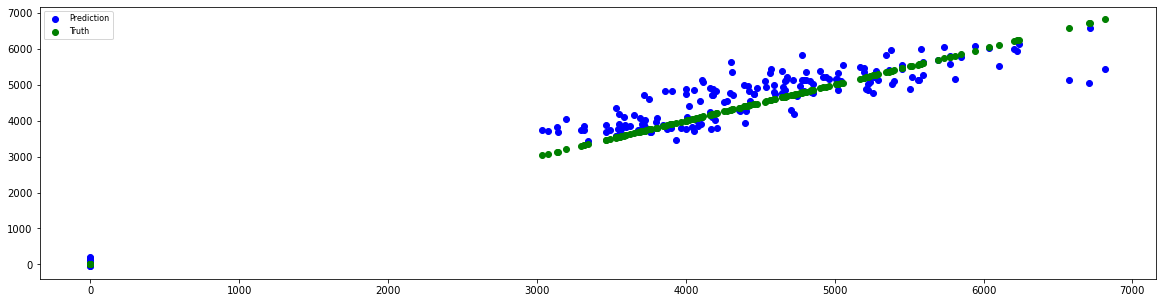

In [46]:
# use automl scoring module to calculate different metrics
scores = scoring.score_regression(
    y_test=score_df[label_column_name],
    y_pred=score_df['Predicted'],
    metrics=list(constants.Metric.SCALAR_REGRESSION_SET)
)

print("[Test data scores]\n")
for key, value in scores.items():    
    print('{}: {:.3f}'.format(key, value))
    
# plot outputs
test_pred = plt.scatter(score_df[label_column_name], score_df['Predicted'], color='b')
test_test = plt.scatter(score_df[label_column_name], score_df[label_column_name], color='g')
plt.legend((test_pred, test_test), ('Prediction', 'Truth'), loc='upper left', fontsize=8)
plt.show()

## Model Deployment

After comparing different metrics with what Hyperdrive tuning approach can archive. The best model from AutoML approach outperforms the Hyperdrive one, register the model, create an inference config and deploy the model as a web service

In [47]:
# register the best model
model = remote_run.register_model(model_name=experiment_name, description=experiment_name)
remote_run.model_id

'sales_automl'

In [48]:
# deploy the best model to ACI
inference_config = InferenceConfig(
    environment=best_run.get_environment(), 
    entry_script=f'{train_folder}/{experiment_name}_scoring.py'
)

aci_config = AciWebservice.deploy_configuration(
    cpu_cores=1, 
    memory_gb=2,
    enable_app_insights=True
)

aci_service_name = f'{experiment_name}_forecast'.replace('_', '-')
aci_service = Model.deploy(ws, aci_service_name, [model], inference_config, aci_config)

aci_service.wait_for_deployment(True)
aci_service.state

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running.........................................
Succeeded
ACI service creation operation finished, operation "Succeeded"


'Healthy'

In [49]:
def print_logs(service):
    logs = service.get_logs()

    for line in logs.split('\n'):
        print(line)

In [50]:
print_logs(aci_service)

2021-01-24T07:27:06,362541566+00:00 - rsyslog/run 
2021-01-24T07:27:06,362541566+00:00 - iot-server/run 
2021-01-24T07:27:06,363462489+00:00 - gunicorn/run 
2021-01-24T07:27:06,392833714+00:00 - nginx/run 
/usr/sbin/nginx: /azureml-envs/azureml_23df5d07c5e8388dac3ecfdf573dafb1/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azureml_23df5d07c5e8388dac3ecfdf573dafb1/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azureml_23df5d07c5e8388dac3ecfdf573dafb1/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azureml_23df5d07c5e8388dac3ecfdf573dafb1/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azureml_23df5d07c5e8388dac3ecfdf573dafb1/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)
rsyslogd

## Test Model Endpoint

After deploying the model into production, as the development team, we can test the endpoint by using a simple Python script to serialize forecast dataset into JSON, send it off to the service, and retrieve the predictions back

In [51]:
# retrieve forecast dataset and convert it to Pandas dataframe
X_query = forecast_dataset.to_pandas_dataframe()

# convert datetime to string, because Timestamps cannot be serialized to JSON.
X_query[time_column_name] = X_query[time_column_name].astype(str)

# The Service object accept the complex dictionary, which is internally converted to JSON string.
# The section 'data' contains the data frame in the form of dictionary.
forecast_sample = json.dumps({'data': X_query.to_dict(orient='records')})
response = aci_service.run(input_data=forecast_sample)

# translate from networkese to datascientese
try: 
    res_dict = json.loads(response)
    y_fcst_all = pd.DataFrame(res_dict['index'])
    y_fcst_all[time_column_name] = pd.to_datetime(y_fcst_all[time_column_name], unit='ms')
    y_fcst_all.pop('_automl_dummy_grain_col')
    y_fcst_all['Forecast'] = res_dict['forecast']    
except:
    print(res_dict)

In [54]:
# print out predictions
y_fcst_all

,Date,Forecast
0,2015-08-01,4679.465140
1,2015-08-02,20.910917
2,2015-08-03,5625.326819
3,2015-08-04,5152.476962
4,2015-08-05,4895.933500
...,...,...
43,2015-09-13,23.245668
44,2015-09-14,5095.804216
45,2015-09-15,4646.240408
46,2015-09-16,4462.076736


## Consume Model Endpoint

With model capability available as REST endpoints, making predictions is just simple as sending HTTP POST requests to its endpoint along with predictors as inputs, the predictions are sent back as HTTP POST responses. Any application can leverage the model.

In [56]:
# obtain score url and authentication key (if available) from Azure Machine Learning Studio then assign them here
score_url = 'http://3e6071ca-ef64-43af-b5f6-07f66e5b72a2.westus.azurecontainer.io/score'
key = ''

# try to predict 2 days
data = {
  "data": [
    {
      "Date": "2015-09-18 00:00:00,000000",
      "DayOfWeek": 5,
      "Open": 1,
      "Promo": 1,
      "StateHoliday": "0",
      "SchoolHoliday": 0
    },
    {
      "Date": "2015-09-19 00:00:00,000000",
      "DayOfWeek": 6,
      "Open": 1,
      "Promo": 0,
      "StateHoliday": "0",
      "SchoolHoliday": 0
    }
  ]
}

# convert to JSON string
input_data = json.dumps(data)

# set the content type
headers = {'Content-Type': 'application/json'}

# if authentication is enabled, set the authorization header
if key is not None or len(key) > 1:
    headers['Authorization'] = f'Bearer {key}'

# make the request and display the response
response = requests.post(score_url, input_data, headers=headers)

# format predictions
response_dict = json.loads(eval(response.text))
response_dict

{'forecast': [4370.493164363835, 4143.606383179988],
 'index': [{'Date': 1442534400000,
   '_automl_dummy_grain_col': '_automl_dummy_grain_col'},
  {'Date': 1442620800000,
   '_automl_dummy_grain_col': '_automl_dummy_grain_col'}]}

In [57]:
y_fcst_all = pd.DataFrame(response_dict['index'])
y_fcst_all[time_column_name] = pd.to_datetime(y_fcst_all[time_column_name], unit='ms')
y_fcst_all.pop('_automl_dummy_grain_col')
y_fcst_all['Forecast'] = response_dict['forecast'] 

y_fcst_all

,Date,Forecast
0,2015-09-18,4370.493164
1,2015-09-19,4143.606383


## Remove Webservice Endpoint

In [ ]:
# delete model endpoint if no long needed
#service = Webservice(ws, aci_service_name)
#service.delete()     # don't do it accidentally